# Tensor Size POC

In [1]:
import torch
import torchvision.transforms as T
import sys

def read_file_into_memory(file_path):
    with open(file_path, 'rb') as file:
        file_content = file.read()
    return file_content

# Example usage
file_path = "/home/austonpramodh/Desktop/Projects/ml-cats-dogs/model-building/cats-dogs/data/PetImages/Dog/12443.jpg"
file_content = read_file_into_memory(file_path)

from PIL import Image
import io

# Assuming file_content is a binary string containing the JPEG image data
# First, convert the binary data into a PIL image
image = Image.open(io.BytesIO(file_content))

image2 = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))

# Then, convert the PIL image into a tensor
image = T.PILToTensor()(image)

image = T.Grayscale()(image)


print("CPU Image Input Tensor - ", image.shape, image.dtype)

print("size of the file in RAW Bytes in KB", sys.getsizeof(file_content)/1024)

calculate_tensor_size = lambda x: sys.getsizeof(x) + torch.numel(x)*x.element_size()

print("size of the file in Tensor Bytes in KB", calculate_tensor_size(image)/1024)


print(image.shape)

print(image2.shape)

CPU Image Input Tensor -  torch.Size([1, 476, 350]) torch.uint8
size of the file in RAW Bytes in KB 26.376953125
size of the file in Tensor Bytes in KB 162.78125
torch.Size([1, 476, 350])
torch.Size([499800])


/tmp/ipykernel_860813/59885666.py:21: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  image2 = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))


# Main Code!

In [2]:
%pip install numpy pandas Pillow matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sys import platform
import subprocess

# if the platform is Mac OS X, install the nightly build of PyTorch
if platform == "darwin":
  print("Installing nightly build of PyTorch for Mac OS X")
  # %pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
  subprocess.run(["pip", "install", "--pre", "torch", "torchvision", "torchaudio", "--extra-index-url", "https://download.pytorch.org/whl/nightly/cpu"])
elif platform == "win32":
  print("Installing PyTorch for Windows")
  # %pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html
  subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio", "--extra-index-url", "https://download.pytorch.org/whl/cu117"])
# if the platform is Linux, install the nightly build of PyTorch
else:
  print("Installing PyTorch for Linux")
  # %pip install torch torchvision torchaudio
  subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio"])

Installing PyTorch for Linux


In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
import numpy as np
from IPython.display import Image
from matplotlib import image, pyplot
import random
%matplotlib inline

In [5]:
# Use GPU if it exists - for faster execution
# Device selection for PyTorch
device = torch.device("cpu")

# Device selection for PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')

device

Using GPU


device(type='cuda', index=0)

In [6]:
# # Download the dataset and unzip - RUN ONLY ONCE!
# zip_file_url = "https://austons-dev-bucket.s3.fr-par.scw.cloud/ml-datasets/cats_and_dogs_filtered.zip"
# import requests, zipfile, sys



# def downloadFile(url: str):
#     local_filename = url.split('/')[-1]
#     # NOTE the stream=True parameter
#     print("Downloading %s!" % local_filename)
#     with requests.get(url, stream=True) as r:
#         r.raise_for_status()
#         total_length = r.headers.get('content-length')
#         if total_length is None: # no content length header
#             f.write(r.content)
#         else:
#             dl = 0
#             total_length  = int(total_length)
#             with open(f"./data/{local_filename}", 'wb') as f:
#                 for chunk in r.iter_content(chunk_size=4096):
#                     dl += len(chunk)
#                     f.write(chunk)
#                     done = int(50 * dl / total_length)
#                     # must be only two decimal places
#                     done_percentage = round(dl / total_length * 100, 2)
#                     sys.stdout.write("\r[%s%s] %s" % ('=' * done, ' ' * (50-done), done_percentage))
#                     sys.stdout.flush()
#     print("\nDownload complete!")
#     return local_filename

# # Check if the data folder exists, if not, create it
# import os
# if not os.path.exists("./data/"):
#     os.makedirs("./data/")

# local_filename = zip_file_url.split('/')[-1]
# # check if the zip file exists, if not, download it
# if not os.path.exists("./data/" + local_filename):
#     downloadFile(zip_file_url)
#     # unzip the file
#     print("Unzipping the file")
#     with zipfile.ZipFile("./data/" + local_filename, 'r') as zip_ref:
#         zip_ref.extractall("./data/")
#     print("Done!")
# else:
#     print("The zipped data file already exists")

In [7]:
# Import all the images into the memory
# Lets check how many files are in the dataset
import os
from typing import List
from matplotlib import image


def getAllFiles(categories: List[str], data_root: str, includeFileData=False) -> dict:
  filesByCategory = {}

  for category in categories:
    count = 0
    full_path = data_root + category

    for file_name in os.listdir(full_path): 
      # Check if the file is an image
      if not file_name.endswith(".jpg") and not file_name.endswith(".jpeg") and not file_name.endswith(".png"):
        continue

      count+=1
      file_path = full_path + "/" + file_name
      file = {
        "file_name": file_name,
        "file_path": file_path,
        "data": None
      }
      
      if includeFileData:
        file["data"] = image.imread(file_path)
        
      if category in filesByCategory.keys():
        filesByCategory[category].append(file)
      else:
        filesByCategory[category] = [file]

    print(f"Total {category} images: {count}")
  return filesByCategory

# Label Encoder!

In [8]:
classes = ["Cat", "Dog"]

class LabelTransformer():
    labels_map = {}
    labels_id_map = {}
    
    def __init__(self, labels):
        # Create a labelMap
        labels_set = set(labels)

        for id,val in enumerate(labels_set):
            self.labels_map[val] = id
            self.labels_id_map[id] = val

    def encoder(self, label):
        return self.labels_map[label]

    def decoder(self, label_encoded):
        return self.labels_id_map[label_encoded]

label_transformer = LabelTransformer(classes)  

In [9]:
dataset_path = os.path.join(os.getcwd(), "data/PetImages/")
filesByCategory = getAllFiles(classes, dataset_path)

Total Cat images: 12501
Total Dog images: 12496


In [10]:
# Test if all images are readable
from torchvision.io import read_image

# for category in filesByCategory.keys():
#   for file in filesByCategory[category]:
#     # if file["data"] is None:
#         try:
#             # file["data"] = 
#             # image.imread(file["file_path"])
#             # Need to fix this reading error, by using image.imread instead of read_image from torchvision
#             read_image(file["file_path"])
#         except:
#             print(f"Error reading file {file['file_path']}")
#             filesByCategory[category].remove(file)

# print(len(filesByCategory["Cat"]))
# print(len(filesByCategory["Dog"]))

------Cat!----
uint8
(400, 320, 3)


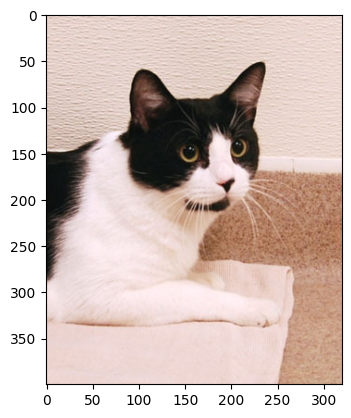

------Dog!----
uint8
(356, 500, 3)


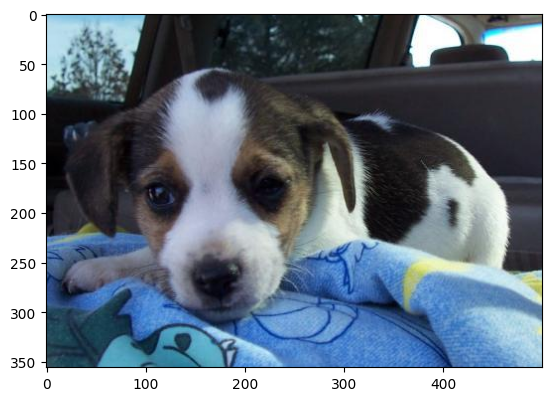

In [11]:
for category in filesByCategory:
  print(f"------{category}!----")
  file_path = filesByCategory[category][0]["file_path"]
  my_image = image.imread(file_path)
  print(my_image.dtype)
  print(my_image.shape)
  pyplot.imshow(my_image)
  pyplot.show()
  

In [12]:
# Create X Train and y Train
files_by_category = filesByCategory
train_XY = []
validation_XY = []

VALIDATION_SPLIT = 0.2

class ImageLabelData():
    def __init__(self, path, label):
        self.path = path
        self.label = label

for i in range(0, len(classes)):
  category = classes[i]
  files = files_by_category[category]
  random.shuffle(files)
  split_index = int(len(files) * VALIDATION_SPLIT)
  training_files = files[split_index:]
  validation_files = files[:split_index]

  for file in training_files:
    # X_train.append(file["file_path"])
    # y_train.append(category)
    train_XY.append(ImageLabelData(file["file_path"], category))
  
  for file in validation_files:
    validation_XY.append(ImageLabelData(file["file_path"], category))

# Random shuffle the data
random.shuffle(train_XY)
random.shuffle(validation_XY)

print(f"Total Training Images: {len(train_XY)}")
print(f"Total Validation Images: {len(validation_XY)}")

Total Training Images: 19998
Total Validation Images: 4999


# Cache Class for DataLoader

In [13]:
# Get Max Memory Available
import psutil
import humanize
import sys


class MemoryCache():
    # static variable for holding the instance reference
    __instances = {}
    
    @staticmethod
    def print_stats():
        for key in MemoryCache.__instances:
            print(MemoryCache.__instances[key])
    
    @staticmethod
    def clear():
        for key in MemoryCache.__instances:
            del MemoryCache.__instances[key]
        print("Memory Cache Cleared")

    # static method for getings instance
    @staticmethod
    def getInstance(max_memory=None, usable_memory_percentage=0.6, DEBUG=False, value_size_getter=None, instance_name="Generic"):
        # check if instance witg the same parameters already exists
        key = instance_name
        if key not in MemoryCache.__instances:
            # if not, create a new instance
            MemoryCache.__instances[key] = MemoryCache(
                max_memory, usable_memory_percentage, DEBUG, value_size_getter, instance_name)
        # return the instance
        return MemoryCache.__instances[key]

    def print(self, *args, **kwargs):
        if self.DEBUG:
            print(*args, **kwargs)

    def __str__(self):
        return f"Name: {self.instance_name}, Max Memory: {humanize.naturalsize(self.max_memory)}, Current Memory: {humanize.naturalsize(self.get_size())}, Entries: {len(self.img_cache)}"

    def __init__(self, max_memory=None, usable_memory_percentage=0.6, DEBUG=False, value_size_getter=None, instance_name=None):
        self.DEBUG = DEBUG
        self.print("Initializing Memory Cache - ", instance_name if instance_name is not None else "No Name!")

        self.instance_name = instance_name

        self.value_size_getter = value_size_getter

        if max_memory is None:
            mem = psutil.virtual_memory()
            # Get the max memory available for the images
            max_memory = mem.available * usable_memory_percentage
        self.max_memory = max_memory
        self.img_cache = {}

        self.print("Memory Cache Initialized")

        self.print(f"Max Memory: {humanize.naturalsize(self.max_memory)}")

    def get_size(self, is_verbose=None):
        is_verbose = is_verbose if is_verbose is not None else self.DEBUG
        size = 0
        for key in self.img_cache:
            size += sys.getsizeof(key)
            if self.value_size_getter is not None:
                size += self.value_size_getter(self.img_cache[key])
            else:
                size += sys.getsizeof(self.img_cache[key])
            if is_verbose:
                self.print(
                    f"Current Memory Used: {humanize.naturalsize(size)}, Max Memory: {humanize.naturalsize(self.max_memory)}, Memory Used: {size/self.max_memory*100:.3f}%")
        return size

    def can_fit_in_memory(self, is_verbose=None):
        is_verbose = is_verbose if is_verbose is not None else self.DEBUG

        obj_size = self.get_size(is_verbose=False)
        if is_verbose:
            self.print(f"Object Size: {humanize.naturalsize(obj_size)} - Max Memory: {humanize.naturalsize(self.max_memory)}")
        
        return obj_size < self.max_memory

    def set(self, key, cache):
        cache_size = None
        if self.value_size_getter is not None:
            cache_size = self.value_size_getter(cache)
        else:
            cache_size = sys.getsizeof(cache)

        if self.can_fit_in_memory(is_verbose=False):
            self.img_cache[key] = cache
            self.print(f"Image Cached: {key} - Size: {humanize.naturalsize(cache_size)}")
        else:
            self.print("Not enough memory to cache the image")

        memory_used = self.get_size(is_verbose=False) / self.max_memory * 100
        self.print(
            f'Data size: {humanize.naturalsize(cache_size)} - Cache size: {humanize.naturalsize(self.get_size(is_verbose=False))} - Memory Used: {memory_used:.3f}% - Entries: {len(self.img_cache)}')

    def get(self, key):
        if key in self.img_cache:
            return self.img_cache[key]
        else:
            return None

    def exists(self, key):
        return key in self.img_cache

# DataLoader

In [14]:
# Create the dataset for DataLoader

torch.manual_seed(17)


class CustomImageDatasetV2(torch.utils.data.Dataset):
    def __init__(self, dataset, pre_cache_transform = None, transform=None, target_transform=None,
                 max_cache_memory_available=None, usable_cache_memory_percentage=0.6, memory_cache_instance_name=None):
        self.dataset = dataset
        self.pre_cache_transform = pre_cache_transform
        self.transform = transform
        self.target_transform = target_transform
        # Since x is a tensor, we need to use the storage() method to get the size of the tensor
        def value_size_getter(x): return sys.getsizeof(x) + torch.numel(x)*x.element_size()
        # def value_size_getter(x): return sys.getsizeof(x)
        self.memory_cache = MemoryCache.getInstance(max_memory=max_cache_memory_available,  usable_memory_percentage=usable_cache_memory_percentage,
                                                    value_size_getter=value_size_getter, DEBUG=False, instance_name=memory_cache_instance_name)
        
    def __len__(self):
        return len(self.dataset)

    def __read_file_into_memory(self, file_path):
        with open(file_path, 'rb') as file:
            file_content = file.read()
        return file_content

    def __getitem__(self, idx):

        label = self.dataset[idx].label
        img_path = self.dataset[idx].path

        image = None
        if self.memory_cache.exists(img_path):
            image = self.memory_cache.get(img_path)
        else:
            # image = self.__read_file_into_memory(img_path)
            image = read_image(img_path)

            if self.pre_cache_transform:
                image = self.pre_cache_transform(image)

            self.memory_cache.set(img_path, image)

        # Image transformation
        if self.transform:
            image = self.transform(image)

        # Label transformation
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


In [15]:
# Create the dataset for DataLoader
from torchvision.io import read_image
import time

torch.manual_seed(17)


class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.dataset[idx].label
        img_path = self.dataset[idx].path
        
        image = read_image(img_path)        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [16]:
from torchvision import transforms


class LambdaModule(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        import types
        assert type(lambd) is types.LambdaType
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


# Create the DataLoader with some transformations
image_size = 224
gpu_available = torch.cuda.is_available()


# Image transformations
image_transforms = {
    'precache':
    torch.nn.Sequential(
        T.Grayscale(),
    ),
    # Train uses data augmentation
    'train':
    torch.nn.Sequential(
        LambdaModule(lambda x: x.to(device)),
        # T.ToPILImage(),
        # T.Resize((image_size, image_size)),
        T.RandomResizedCrop(image_size),
        T.RandomHorizontalFlip(),
        # LambdaModule(lambda x: x.squeeze()),
        T.ConvertImageDtype(torch.float),
    ),
    # Validation does not use augmentation
    'val':
    torch.nn.Sequential(
        LambdaModule(lambda x: x.to(device)),
        T.Resize((image_size, image_size)),
        # LambdaModule(lambda x: x.squeeze()),
        T.ConvertImageDtype(torch.float),
    ),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        T.ToPILImage(),
        T.Resize((image_size, image_size)),
        T.Grayscale(),
        T.ToTensor(),
    ]),
}

In [17]:
# Test transformer on all images since its throwing an error

# i = 0
# while len(train_XY) > i:
#     try:
#         image = read_image(train_XY[i].path)
#         image_transforms["train"](image)
#         image_transforms["val"](image)
#         image_transforms["test"](image)
#         i += 1
#     except:
#         print(f"Error on image {train_XY[i].path}")
#         # Remove the image from the training set
#         train_XY.pop(i)

# # Test transformer on all images since its throwing an error
# i = 0
# while len(validation_XY) > i:
#     try:
#         image = read_image(validation_XY[i].path)
#         image_transforms["train"](image)
#         image_transforms["val"](image)
#         image_transforms["test"](image)
#         i += 1
#     except:
#         print(f"Error on image {validation_XY[i].path}")
#         # Remove the image from the training set
#         validation_XY.pop(i)

# # Valid Images num
# print(f"Total Training Images: {len(train_XY)}")
# print(f"Total Validation Images: {len(validation_XY)}")

In [18]:
# class LambdaModule(nn.Module):
#     def __init__(self, lambd):
#         super().__init__()
#         import types
#         assert type(lambd) is types.LambdaType
#         self.lambd = lambd

#     def forward(self, x):
#         return self.lambd(x)
    
# # Create the DataLoader with some transformations
# image_size = 224
# transform = T.Compose([
#     T.ToPILImage(),
#     T.Resize((image_size, image_size)),
#     T.RandomResizedCrop(image_size),
#     T.RandomHorizontalFlip(),
#     T.Grayscale(),
#     T.ToTensor(),
#     # LambdaModule(lambda x: x.squeeze())
# ])

# gpu_available = torch.cuda.is_available()

# transform_gpu = torch.nn.Sequential(
#     # T.ToPILImage(),
#     T.Resize((image_size, image_size)),
#     T.RandomResizedCrop(image_size),
#     T.RandomHorizontalFlip(),
#     T.Grayscale(),
#     # LambdaModule(lambda x: x.squeeze()),
#     T.ConvertImageDtype(torch.float),
# )


# # Testing the Transformer - CPU
# my_image = read_image(train_XY[0].path)
# print("CPU Image Input - ", my_image.shape, my_image.dtype)
# print("CPU Image Input - ", my_image)
# transformed_image = transform(my_image)
# print("CPU Image Output - ", transformed_image)
# print("CPU Image Output - ", transformed_image.shape, transformed_image.dtype)
# # pyplot.imshow(transformed_image.squeeze(), cmap="gray")

# # Testing the Transformer - GPU
# my_image_gpu = read_image(train_XY[0].path)
# print("GPU Image Input - ", my_image_gpu.shape, my_image_gpu.dtype)
# my_image_gpu = my_image.to(device)
# transformed_image_gpu = transform_gpu(my_image_gpu)


# # # # Show the transformed image
# gpu_cpu_img = transformed_image_gpu.squeeze().cpu()
# pyplot.imshow(gpu_cpu_img, cmap="gray")
# print("GPU Image Output - ", transformed_image_gpu)
# print("GPU Image Output - ", transformed_image_gpu.shape, transformed_image_gpu.dtype)

In [19]:
from PIL import Image as PILImage

batch_size = 64

class FileBinaryToTensorTransformerWrapper():
    transformer = None
    def __init__(self, transformer, device = None):
        self.transformer = transformer
        self.device = device

    def __call__(self, *args, **kwds):
        image = PILImage.open(io.BytesIO(args[0]))

        pilTransform = T.PILToTensor()

        transformedImage = pilTransform(image)

        if self.device:
            transformedImage = transformedImage.to(device)

        return self.transformer(transformedImage)




# train_transformer = FileBinaryToTensorTransformerWrapper(image_transforms["train"], device)
train_transformer = image_transforms["train"]
# validation_transformer = FileBinaryToTensorTransformerWrapper(image_transforms["val"], device)
validation_transformer = image_transforms["val"]

train_dataset = CustomImageDatasetV2(
    dataset=train_XY,
    transform=train_transformer,
    pre_cache_transform=image_transforms["precache"],
    target_transform=label_transformer.encoder,
    usable_cache_memory_percentage=0.5,
    memory_cache_instance_name="Train Memory Cache")
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=False)

validation_dataset = CustomImageDatasetV2(
            dataset=validation_XY,
            transform=validation_transformer, 
            pre_cache_transform=image_transforms["precache"],
            target_transform=label_transformer.encoder,
            usable_cache_memory_percentage=0.2,
            memory_cache_instance_name="Validation Memory Cache")
validation_dl = DataLoader(validation_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=False)

In [20]:
MemoryCache.print_stats()

Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 0 Bytes, Entries: 0
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 0 Bytes, Entries: 0


/home/austonpramodh/Desktop/Projects/ml-cats-dogs/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[0.1922, 0.1922, 0.1922,  ..., 0.2196, 0.2196, 0.2275],
        [0.1922, 0.1882, 0.1882,  ..., 0.2314, 0.2275, 0.2314],
        [0.2000, 0.1922, 0.1804,  ..., 0.2314, 0.2353, 0.2353],
        ...,
        [0.3216, 0.3137, 0.3294,  ..., 0.3529, 0.3412, 0.3569],
        [0.3176, 0.2980, 0.3255,  ..., 0.3686, 0.3647, 0.3490],
        [0.2941, 0.2784, 0.3059,  ..., 0.3451, 0.3647, 0.3529]])

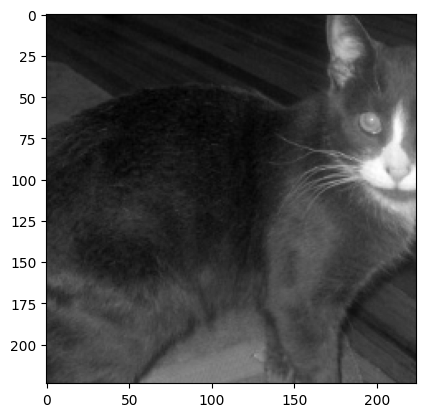

In [21]:
from typing import Any
from PIL import Image

image, label = train_dl.dataset[0]
# pilTransform = T.ToPILImage()
# transformedImage = pilTransform(image)
# display(transformedImage)
# print(image)


# Need to write new Transformer for binary data
# image = Image.open(io.BytesIO(image))

# transformerV2 = T.Compose([
#     T.Resize((image_size, image_size)),
#     T.RandomResizedCrop(image_size),
#     T.RandomHorizontalFlip(),
#     T.Grayscale(),
#     T.PILToTensor(),
# ])

transformerV2 = torch.nn.Sequential(
    T.Resize((image_size, image_size)),
    T.RandomResizedCrop(image_size),
    T.RandomHorizontalFlip(),
    T.Grayscale(),
    T.ConvertImageDtype(torch.float),
)

# class FileBinaryToTensorTransformerWrapper():
#     transformer = None
#     def __init__(self, transformer, device = None):
#         self.transformer = transformer
#         self.device = device

#     def __call__(self, *args: Any, **kwds: Any) -> Any:
#         image = Image.open(io.BytesIO(args[0]))

#         pilTransform = T.PILToTensor()

#         transformedImage = pilTransform(image)

#         if self.device:
#             transformedImage = transformedImage.to(device)

#         return self.transformer(transformedImage)


# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# print("device",device)
# my_transformer = FileBinaryToTensorTransformerWrapper(transformerV2, device=device)
# image = my_transformer(image)
# print(image)

image = image.squeeze().cpu()
pyplot.imshow(image, cmap="gray")

image

Loading dataset....:   0%|          | 0/313 [00:02<?, ?batch/s]


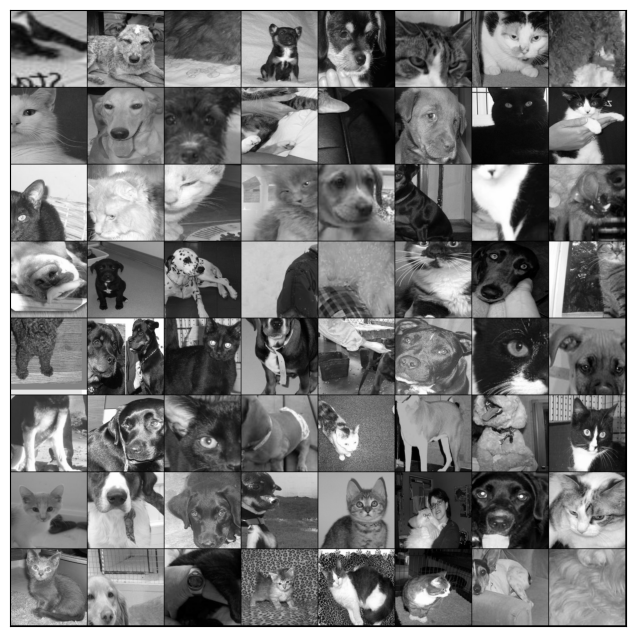

In [22]:
from tqdm import tqdm


def show_images(images, nmax=64):
    fig, ax = pyplot.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    images = images.cpu()
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for batch in tqdm(dl, "Loading dataset....", unit="batch"):
        images, labels = batch
        show_images(images, nmax)
        break

show_batch(train_dl)

In [23]:
train_dataset[0][0].shape

torch.Size([1, 224, 224])

# CNN Model!

In [24]:
# Craete a neural network from pytorch
# https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [25]:
# Craete a neural network from pytorch
# class Cnn(nn.Module):
#     def __init__(self):
#         super(Cnn,self).__init__()
        
#         self.layer1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0, stride=2)
#         self.bactchnorm = nn.BatchNorm2d(num_features=16)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=2)

#         self.fc1 = nn.Linear(55 * 55 * 16, 2)
#         self.relu = nn.ReLU()
        
        
#     def forward(self,x):
#         # Layer 1
#         out = self.layer1(x)
#         out = self.bactchnorm(out)
#         out = self.relu(out)
#         out = self.maxpool(out)
#         # Layer 1 -----

#         out = self.relu(out)
#         out = out.view(out.size(0), out.size(1)*out.size(2)* out.size(3))
#         out = self.fc1(out)
#         return out

# ------------

# Model Instantiation

In [43]:
model = Cnn().to(device)

## HyperParameters

In [44]:
train_acc_loss = []
val_acc_loss = []
learning_rate = 0.001
total_epochs = 20


optimizer = optim.Adam(params = model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [45]:
epoch_completed = 0

In [46]:
from tqdm import tqdm


# Training loop
for epoch in range(total_epochs):
    if epoch < epoch_completed:
        print(f"Skipping epoch {epoch+1}")
        continue
    model.train()
    t0 = time.time()

    # epoch_accuracy=0
    # epoch_loss=0
    total_loss = 0.0  # Initialize total training loss for the epoch
    total_correct = 0
    total_samples=0
    
    for batch in tqdm(train_dl, desc="Training", unit="batch"):
        images, labels = batch

        # Convert to the device we are using
        images = images.to(device)
        labels = labels.to(device)

        # Get the output and loss
        output = model(images)
        loss = criterion(output, labels)

        # Backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate the accuracy and loss for training
        total_loss += loss.item() * images.size(0)  # Accumulate the training loss
        _, predicted = torch.max(output, 1)
        # Check if preds === a
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = total_loss / len(train_dl.dataset)
    epoch_accuracy = total_correct / total_samples
    train_acc_loss.append([epoch_accuracy, epoch_loss])
    
    t1 = time.time()

    print(f"Epoch [{epoch+1}/{total_epochs}], Training Accuracy: {epoch_accuracy:.4f}, Training Loss: {epoch_loss:.4f}, Time: {t1-t0:.2f} seconds")
    # Validation
    model.eval()
    total_loss_val = 0.0
    total_correct_val = 0
    total_samples_val = 0

    t0 = time.time()
    
    with torch.no_grad():
        for batch in tqdm(validation_dl, desc="Validating", unit="batch"):
            images, labels = batch

            # Convert to the device we are using
            images = images.to(device)
            labels = labels.to(device)

            # Get the output and loss
            outputs = model(images)
            loss_val = criterion(outputs, labels)
            total_loss_val += loss_val.item() * images.size(0)  # Accumulate the validation loss

            _, predicted = torch.max(outputs, dim=1)
            total_correct_val += (predicted == labels).sum().item()
            total_samples_val += labels.size(0)

    # Compute average validation loss for the epoch
    epoch_loss_val = total_loss_val / len(validation_dl.dataset)
    epoch_accuracy_val = total_correct_val / total_samples_val
    
    val_acc_loss.append([epoch_accuracy_val, epoch_loss_val])

    t1 = time.time()
    print(f'Epoch [{epoch+1}/{total_epochs}], Validation Loss: {epoch_loss_val:.4f}, Validation Accuracy: {epoch_accuracy_val:.4f}, Time: {t1-t0:.2f} seconds')
    print("=====================================================================================================")
    MemoryCache.print_stats()
    print("=====================================================================================================")

    epoch_completed = epoch


Training: 100%|██████████| 313/313 [00:07<00:00, 39.94batch/s]


Epoch [1/20], Training Accuracy: 0.6321, Training Loss: 0.6382, Time: 7.84 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 75.63batch/s]


Epoch [1/20], Validation Loss: 0.5916, Validation Accuracy: 0.6817, Time: 1.05 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 39.90batch/s]


Epoch [2/20], Training Accuracy: 0.6920, Training Loss: 0.5822, Time: 7.85 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 71.89batch/s]


Epoch [2/20], Validation Loss: 0.5722, Validation Accuracy: 0.6987, Time: 1.10 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 39.41batch/s]


Epoch [3/20], Training Accuracy: 0.7184, Training Loss: 0.5493, Time: 7.94 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 72.50batch/s]


Epoch [3/20], Validation Loss: 0.4972, Validation Accuracy: 0.7604, Time: 1.09 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 39.86batch/s]


Epoch [4/20], Training Accuracy: 0.7311, Training Loss: 0.5342, Time: 7.85 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 75.98batch/s]


Epoch [4/20], Validation Loss: 0.4825, Validation Accuracy: 0.7648, Time: 1.04 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 40.16batch/s]


Epoch [5/20], Training Accuracy: 0.7423, Training Loss: 0.5149, Time: 7.80 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 74.55batch/s]


Epoch [5/20], Validation Loss: 0.5855, Validation Accuracy: 0.6979, Time: 1.06 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 42.25batch/s]


Epoch [6/20], Training Accuracy: 0.7525, Training Loss: 0.5026, Time: 7.41 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 77.62batch/s]


Epoch [6/20], Validation Loss: 0.4570, Validation Accuracy: 0.7804, Time: 1.02 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 42.93batch/s]


Epoch [7/20], Training Accuracy: 0.7566, Training Loss: 0.4937, Time: 7.29 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 77.24batch/s]


Epoch [7/20], Validation Loss: 0.4773, Validation Accuracy: 0.7724, Time: 1.02 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 42.16batch/s]


Epoch [8/20], Training Accuracy: 0.7636, Training Loss: 0.4858, Time: 7.43 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 78.81batch/s]


Epoch [8/20], Validation Loss: 0.4822, Validation Accuracy: 0.7710, Time: 1.00 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 41.05batch/s]


Epoch [9/20], Training Accuracy: 0.7695, Training Loss: 0.4761, Time: 7.63 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 74.98batch/s]


Epoch [9/20], Validation Loss: 0.5231, Validation Accuracy: 0.7453, Time: 1.05 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 40.82batch/s]


Epoch [10/20], Training Accuracy: 0.7752, Training Loss: 0.4617, Time: 7.67 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 76.34batch/s]


Epoch [10/20], Validation Loss: 0.5883, Validation Accuracy: 0.7059, Time: 1.04 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 41.81batch/s]


Epoch [11/20], Training Accuracy: 0.7817, Training Loss: 0.4590, Time: 7.49 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 77.73batch/s]


Epoch [11/20], Validation Loss: 0.4762, Validation Accuracy: 0.7592, Time: 1.02 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 40.91batch/s]


Epoch [12/20], Training Accuracy: 0.7891, Training Loss: 0.4444, Time: 7.65 seconds


Validating: 100%|██████████| 79/79 [00:00<00:00, 79.09batch/s]


Epoch [12/20], Validation Loss: 0.3995, Validation Accuracy: 0.8142, Time: 1.00 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 41.40batch/s]


Epoch [13/20], Training Accuracy: 0.7866, Training Loss: 0.4457, Time: 7.56 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 78.37batch/s]


Epoch [13/20], Validation Loss: 0.5700, Validation Accuracy: 0.7285, Time: 1.01 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:08<00:00, 36.21batch/s]


Epoch [14/20], Training Accuracy: 0.7954, Training Loss: 0.4357, Time: 8.65 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.13batch/s]


Epoch [14/20], Validation Loss: 0.4342, Validation Accuracy: 0.7886, Time: 1.43 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:08<00:00, 34.98batch/s]


Epoch [15/20], Training Accuracy: 0.7931, Training Loss: 0.4349, Time: 8.95 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 69.13batch/s]


Epoch [15/20], Validation Loss: 0.4609, Validation Accuracy: 0.7900, Time: 1.14 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 39.45batch/s]


Epoch [16/20], Training Accuracy: 0.7949, Training Loss: 0.4230, Time: 7.93 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 77.80batch/s]


Epoch [16/20], Validation Loss: 0.3941, Validation Accuracy: 0.8238, Time: 1.02 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 41.08batch/s]


Epoch [17/20], Training Accuracy: 0.8031, Training Loss: 0.4161, Time: 7.62 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 74.36batch/s]


Epoch [17/20], Validation Loss: 0.3656, Validation Accuracy: 0.8342, Time: 1.06 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 41.67batch/s]


Epoch [18/20], Training Accuracy: 0.8033, Training Loss: 0.4158, Time: 7.51 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 77.80batch/s]


Epoch [18/20], Validation Loss: 0.7228, Validation Accuracy: 0.6761, Time: 1.02 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 39.93batch/s]


Epoch [19/20], Training Accuracy: 0.8056, Training Loss: 0.4167, Time: 7.84 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 74.51batch/s]


Epoch [19/20], Validation Loss: 0.4374, Validation Accuracy: 0.8062, Time: 1.06 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


Training: 100%|██████████| 313/313 [00:07<00:00, 40.35batch/s]


Epoch [20/20], Training Accuracy: 0.8054, Training Loss: 0.4098, Time: 7.76 seconds


Validating: 100%|██████████| 79/79 [00:01<00:00, 73.06batch/s]

Epoch [20/20], Validation Loss: 0.3818, Validation Accuracy: 0.8266, Time: 1.08 seconds
Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


In [47]:
MemoryCache.print_stats()

Name: Train Memory Cache, Max Memory: 11.9 GB, Current Memory: 3.0 GB, Entries: 19998
Name: Validation Memory Cache, Max Memory: 4.7 GB, Current Memory: 755.9 MB, Entries: 4999


In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 29,312 trainable parameters


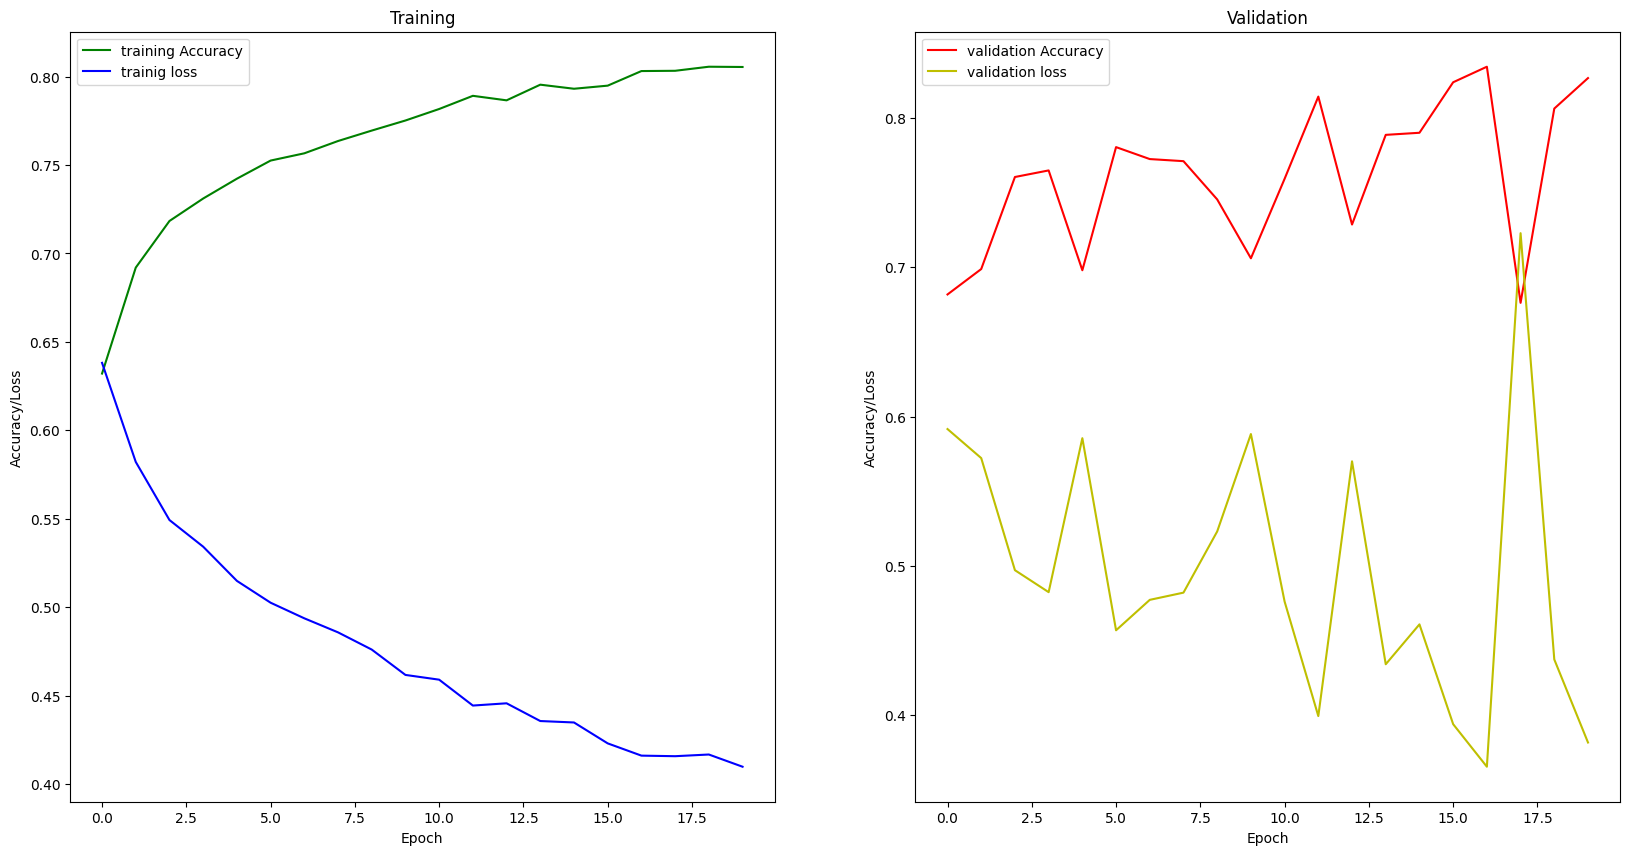

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a plot for accuracy against each epoch
fig, (ax1, ax2) = plt.subplots(nrows=1,
                                        ncols=2,
                                        figsize=(20, 10))
# Training -----
# Train Accuracy per epoch
y = [acc for acc, loss in train_acc_loss]
x = np.arange(len(y))
ax1.plot(x, y, color='g', label='training Accuracy')


# Train Loss per epoch
y = [loss for acc, loss in train_acc_loss]
ax1.plot(x, y, color='b', label='trainig loss')


# Validation -----
# Validation Accuracy per epoch
y = [acc for acc, loss in val_acc_loss]
ax2.plot(x, y, color='r', label='validation Accuracy')

# Validation loss per epoch
y = [loss for acc, loss in val_acc_loss]
ax2.plot(x, y, color='y', label='validation loss')

ax1.set(title="Training", 
      ylabel="Accuracy/Loss", xlabel="Epoch");

ax2.set(title="Validation", 
      ylabel="Accuracy/Loss", xlabel="Epoch");

# Adding legend, which helps us recognize the curve according to it's color
ax1.legend()
ax2.legend() 

# Saving the Model State

In [50]:

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
layer1.0.weight 	 torch.Size([16, 1, 3, 3])
layer1.0.bias 	 torch.Size([16])
layer1.1.weight 	 torch.Size([16])
layer1.1.bias 	 torch.Size([16])
layer1.1.running_mean 	 torch.Size([16])
layer1.1.running_var 	 torch.Size([16])
layer1.1.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([32, 16, 3, 3])
layer2.0.bias 	 torch.Size([32])
layer2.1.weight 	 torch.Size([32])
layer2.1.bias 	 torch.Size([32])
layer2.1.running_mean 	 torch.Size([32])
layer2.1.running_var 	 torch.Size([32])
layer2.1.num_batches_tracked 	 torch.Size([])
layer3.0.weight 	 torch.Size([64, 32, 3, 3])
layer3.0.bias 	 torch.Size([64])
layer3.1.weight 	 torch.Size([64])
layer3.1.bias 	 torch.Size([64])
layer3.1.running_mean 	 torch.Size([64])
layer3.1.running_var 	 torch.Size([64])
layer3.1.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([10, 576])
fc1.bias 	 torch.Size([10])
fc2.weight 	 torch.Size([2, 10])
fc2.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {0: {'s

In [51]:
# Save the model state
torch.save(model.state_dict(), './model-state.pth')

# New - Saving the model in onxx format

In [52]:
%pip install onnx onnxscript

Note: you may need to restart the kernel to use updated packages.


In [53]:
torch_model = Cnn()
torch_model.load_state_dict(torch.load('./model-state.pth'))

torch_model.eval()

torch_input = torch.randn(1, 1, 224, 224)
onnx_program = torch.onnx.dynamo_export(torch_model, torch_input)

# onnx_program.save("my_cats_dogs_cnn_model.onnx")

/home/austonpramodh/Desktop/Projects/ml-cats-dogs/.venv/lib/python3.11/site-packages/torch/onnx/_internal/exporter.py:130: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(
/home/austonpramodh/Desktop/Projects/ml-cats-dogs/.venv/lib/python3.11/site-packages/torch/onnx/_internal/fx/passes/readability.py:53: UserWarning: Attempted to insert a get_attr Node with no underlying reference in the owning GraphModule! Call GraphModule.add_submodule to add the necessary submodule, GraphModule.add_parameter to add the necessary Parameter, or nn.Module.register_buffer to add the necessary buffer
  new_node = self.module.graph.get_attr(normalized_name)
/home/austonpramodh/Desktop/Projects/ml-cats-dogs/.venv/lib/python3.11/site-packages/torch/fx/graph.py:1377: UserWarning: Node layer1_1_running_mean target layer1/1/running_mean layer1/1/running_mean of  does not 

LoADING ONNX Model in memory to check if everythings working!

In [54]:
import onnx
onnx_model = onnx.load("my_cats_dogs_cnn_model.onnx")
onnx.checker.check_model(onnx_model)

In [55]:
%pip install onnxruntime

Note: you may need to restart the kernel to use updated packages.


# Inferencing with Onnx

In [56]:
import onnxruntime

url = "https://i.redd.it/02rmlxw3lpa11.jpg"
from PIL import Image
import requests
from io import BytesIO

response = requests.get(url)
img = Image.open(BytesIO(response.content))
# display(img)

image_size = 224
# Transform this image
transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.Grayscale(),
    T.ToTensor(),
])


img_transformed = transform(img)
torch_input = img_transformed.unsqueeze(0)
print(img_transformed.shape)
print(torch_input.shape)
onnx_input = onnx_program.adapt_torch_inputs_to_onnx(torch_input)
# print(f"Input length: {len(onnx_input)}")
# print(f"Sample input: {onnx_input}")
print("torch_input", torch_input)
print("onnx_input", onnx_input)
ort_session = onnxruntime.InferenceSession("./my_cats_dogs_cnn_model.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

# output = session.run(None, {input_name: transformed_img_tensor_unsqueezed.numpy()})[0]
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)

model.to("cpu")
torch_output = model(torch_input).detach().numpy()[0]

print(torch_output)
print(onnxruntime_outputs[0][0])

# Compare the results to check if they are the similar
print("outputs are same!" if torch_output.argmax() == onnxruntime_outputs[0][0].argmax() else "Not the same")

torch.Size([1, 224, 224])
torch.Size([1, 1, 224, 224])
torch_input tensor([[[[0.6039, 0.6078, 0.6157,  ..., 0.9686, 0.9686, 0.9686],
          [0.6157, 0.6196, 0.6235,  ..., 0.9686, 0.9686, 0.9686],
          [0.6353, 0.6431, 0.6471,  ..., 0.9686, 0.9647, 0.9647],
          ...,
          [0.2000, 0.2000, 0.1961,  ..., 0.5137, 0.5255, 0.5294],
          [0.1961, 0.1961, 0.2000,  ..., 0.5216, 0.5333, 0.5255],
          [0.1961, 0.1961, 0.2000,  ..., 0.5176, 0.5373, 0.5373]]]])
onnx_input (tensor([[[[0.6039, 0.6078, 0.6157,  ..., 0.9686, 0.9686, 0.9686],
          [0.6157, 0.6196, 0.6235,  ..., 0.9686, 0.9686, 0.9686],
          [0.6353, 0.6431, 0.6471,  ..., 0.9686, 0.9647, 0.9647],
          ...,
          [0.2000, 0.2000, 0.1961,  ..., 0.5137, 0.5255, 0.5294],
          [0.1961, 0.1961, 0.2000,  ..., 0.5216, 0.5333, 0.5255],
          [0.1961, 0.1961, 0.2000,  ..., 0.5176, 0.5373, 0.5373]]]]),)
[-0.15709263 -0.8587623 ]
[0.59546477 0.04780054]
outputs are same!


In [57]:
import torch.nn.functional as F
output = torch_model(torch_input)

# Apply softmax to the output
pred = F.softmax(output, dim=1)

# Get the class with the highest probability
output_class_id = pred.argmax(dim=1).detach().numpy()[0]
print(output_class_id, pred)

0 tensor([[0.6686, 0.3314]], grad_fn=<SoftmaxBackward0>)


## Inferencing!

In [58]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import torch.nn.functional as F

## *Run the CNN Model class from above blocks*

In [59]:
# Load the model
new_model = Cnn()
new_model.load_state_dict(torch.load(
        "./model-state.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

## *Run the LabelEncoder class from above blocks*

Transformed Image


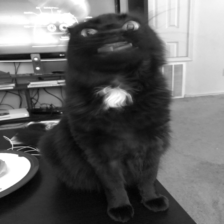

Tensor -> PIL Image


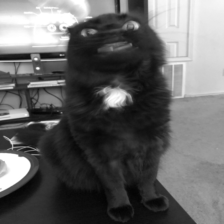

torch.Size([1, 224, 224])
torch.Size([1, 1, 224, 224])
output_class: Dog
**************************************************
Its a  Dog with a probability of  0.6685579
**************************************************
Class:  Dog Prob:  0.6685579
Class:  Cat Prob:  0.33144215


{'Dog': 0.6685579, 'Cat': 0.33144215}

In [60]:
# url="https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"
# url="https://images.pexels.com/photos/2023384/pexels-photo-2023384.jpeg"
# url="https://cdn.pixabay.com/photo/2017/06/20/22/14/man-2425121_960_720.jpg"
# url = "https://media.geeksforgeeks.org/wp-content/uploads/20210318103632/gfg-300x300.png"
url = "https://i.redd.it/02rmlxw3lpa11.jpg"
from PIL import Image
import requests
from io import BytesIO

response = requests.get(url)
img = Image.open(BytesIO(response.content))
# display(img)

image_size = 224
# Transform this image
transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.Grayscale(),
    # T.ToTensor(),
])

# inference this image
print("Transformed Image")
transformed_img = transform(img)
display(transformed_img)

transformed_img_tensor = T.ToTensor()(transformed_img)

print("Tensor -> PIL Image")
img_n = T.ToPILImage()(transformed_img_tensor)
display(img_n)
# Inference this
new_model.eval()

print(transformed_img_tensor.size())
transformed_img_tensor_unsqueezed = transformed_img_tensor.unsqueeze(0)
print(transformed_img_tensor_unsqueezed.size())


output = new_model(transformed_img_tensor_unsqueezed)

# Apply softmax to the output
pred = F.softmax(output, dim=1)

# Get the class with the highest probability
output_class_id = pred.argmax(dim=1).detach().numpy()[0]

output_class = label_transformer.decoder(output_class_id)
print("output_class:", output_class)

print("*"*50)
print("Its a ", output_class, "with a probability of ", pred.detach().numpy()[0][output_class_id])
print("*"*50)

# Map the output class id to the name of the class
probs = {}
for i in range(len(pred.detach().numpy()[0])):
    print("Class: ", label_transformer.decoder(i), "Prob: ", pred.detach().numpy()[0][i])
    probs[label_transformer.decoder(i)] = pred.detach().numpy()[0][i]
probs

In [ ]:
import urllib.request

from PIL import Image

urllib.request.urlretrieve(
  'https://media.geeksforgeeks.org/wp-content/uploads/20210318103632/gfg-300x300.png',
   "gfg.png")
  
img = Image.open("gfg.png")
display(img)

In [ ]:
from PIL import Image
import requests
from io import BytesIO

# url = "https://media.geeksforgeeks.org/wp-content/uploads/20210318103632/gfg-300x300.png"
url = "https://www.inferdo.com/img/label-1.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)

In [ ]:
def get_thirdparty_image_labels(url):
    payload = {"url": url}
    headers = {
      "content-type": "application/json",
      "X-RapidAPI-Key": "c888010467msha782d4c79ee3a6fp110abbjsndc0927e072a6",
      "X-RapidAPI-Host": "image-labeling1.p.rapidapi.com"
    }
    response = requests.request("POST", "https://image-labeling1.p.rapidapi.com/img/label", headers=headers, json=payload)

    return response.json()


In [ ]:
import requests


# url = "https://i.redd.it/02rmlxw3lpa11.jpg"
# url = "https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"
api_url = "https://image-labeling1.p.rapidapi.com/img/label"
url = "https://www.inferdo.com/img/label-1.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)

get_thirdparty_image_labels(url)